# NumPyro and Hamiltonian Monte Carlo

In this tutorial we will see how we to integrate our ∂Lux optical models with the Probabilistic Programming Language (PPL) NumPyro. This allows us to run a subset of MCMC algorithms known as Hamiltonian Monte Carlo (HMC), which take advantage of autodiff to infer the relationship between a large number of parameters.

In this example we will simulate a binary star through a simple optical system, and simultaneously infer the stellar and optical parameters.

In [13]:
# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import jax.random as jr
import jax.numpy as np
import dLux as dl
import dLux.utils as dlu
import dLux.layers as dll
import matplotlib.pyplot as plt

# Set global plotting parameters
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

Let's construct the source and optics. In this case, we will use the `AlphaCen` source from the [`dLuxToliman`](https://github.com/maxecharles/dLuxToliman) package as it gives separation in arcseconds and flux in log units. This will make our NumPyro sampling functions simpler.

In [17]:
from dLuxToliman import AlphaCen

# Use the AlphaCen object for separation in units of arcseconds, and flux in log
source = AlphaCen()
source = source.set(['log_flux', 'separation'], [3.5, 0.1])

# Aperture properties
wf_npix = 128
diameter = 1

# Construct an aperture with a single spider as the asymmetry
coords = dlu.pixel_coords(5*wf_npix, diameter)
circle = dlu.circle(coords, diameter/2)
transmission = dlu.combine([circle], 5)

# Zernike aberrations
zernike_indexes = np.arange(4, 11)
true_coeffs = 1e-9 * jr.normal(jr.PRNGKey(0), zernike_indexes.shape)
coords = dlu.pixel_coords(wf_npix, diameter)
basis = np.array([dlu.zernike(i, coords, diameter) for i in zernike_indexes])

# aperture = dl.ApertureFactory(wf_npix, radial_orders=radial_terms, coefficients=true_coeffs)

layers = [('aperture', dll.BasisOptic(transmission, basis, true_coeffs, normalise=True))]

# Psf properties
psf_npixels = 16
psf_pixel_scale = 0.03

# Construct
optics = dl.AngularOptics(wf_npix, diameter, layers, psf_npixels, psf_pixel_scale)

# Construct Telescope
telescope = dl.Telescope(optics, ('source', source))

Now, let's create simulated data and examine them.

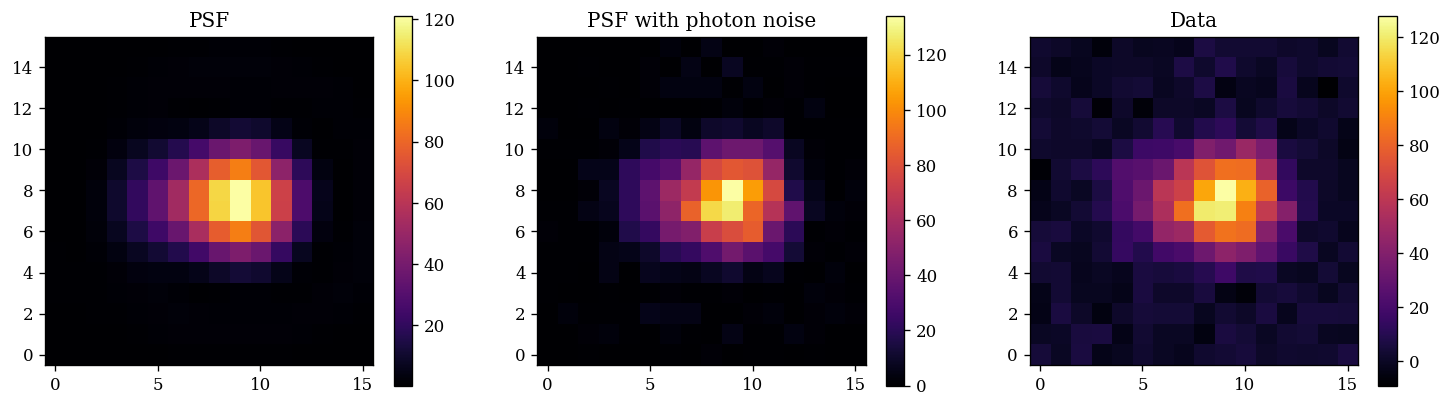

In [18]:
## Generate psf
psf = telescope.model()
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 3*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data = psf_photon + bg_noise

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("PSF with photon noise")
plt.imshow(psf_photon)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Data")
plt.imshow(data)
plt.colorbar()
plt.show()

---

# Inference with NumPyro

Awesome, now we are going to try and infer these parameters using HMC. There are quite a few different parameters we want to infer:

##  Source Parameters
 - The $(x,y)$ mean position (2 parameters)
 - The separation (1 parameter)
 - The position angle (1 parameter)
 - The mean flux (1 parameter)
 - The contrast ratio (1 parameter)
 
## Optical Parameters
 - The Zernike aberration coefficients (7 parameters)
 
This gives us a total of 13 parameters, which is quite high dimensional for regular MCMC algorithms.

Next, we construct our NumPyro sampling function. In this function we need to define prior distribution variables for our parameters, along with the corresponding parameter path. This allows for NumPyro to simultaneously sample the posterior of all parameters by taking advantage of the differentiable nature of these models.

With these parameters, we create a `plate` which defines our data. We use a Poisson likelihood since photon noise is our dominant noise source.

In [19]:
# PPL
import numpyro as npy
import numpyro.distributions as dist

parameters = ['x_position', 'y_position', 'separation', 'position_angle', 
    'log_flux', 'contrast']

def psf_model(data, model):
    """
    Define the numpyro function
    """
    values = [
        npy.sample("x",        dist.Uniform(-0.1, 0.1)),
        npy.sample("y",        dist.Uniform(-0.1, 0.1)),
        npy.sample("r",        dist.Uniform(0.01, 0.5)),
        npy.sample("theta",    dist.Uniform(80, 100)),
        npy.sample("log_flux", dist.Uniform(3, 4)),
        npy.sample("contrast", dist.Uniform(1, 5)),
    ]

    with npy.plate("data", len(data.flatten())):
        poisson_model = dist.Poisson(
            model.set(parameters, values).model().flatten())
        return npy.sample("psf", poisson_model, obs=data.flatten())

Using the model above, we can now sample from the posterior distribution using the No U-Turn Sampler (NUTS).

In [20]:
from jax import device_count
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=2000,
    num_samples=2000,
    num_chains=device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data, telescope)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 4min 22s, sys: 23.3 s, total: 4min 45s
Wall time: 53.3 s


Let's examine the summary. Note: here we want to make sure that all the `r_hat` values are $\sim1$.

In [21]:
sampler.print_summary()
values_out = sampler.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  contrast      2.59      0.25      2.58      2.19      3.01   4132.96      1.00
  log_flux      3.51      0.01      3.51      3.50      3.52   6821.95      1.00
         r      0.10      0.00      0.10      0.09      0.10   4214.09      1.00
     theta     88.70      1.60     88.71     86.09     91.31   4491.81      1.00
         x      0.01      0.00      0.01      0.00      0.01   3672.32      1.00
         y     -0.00      0.00     -0.00     -0.00      0.00   4784.68      1.00

Number of divergences: 0


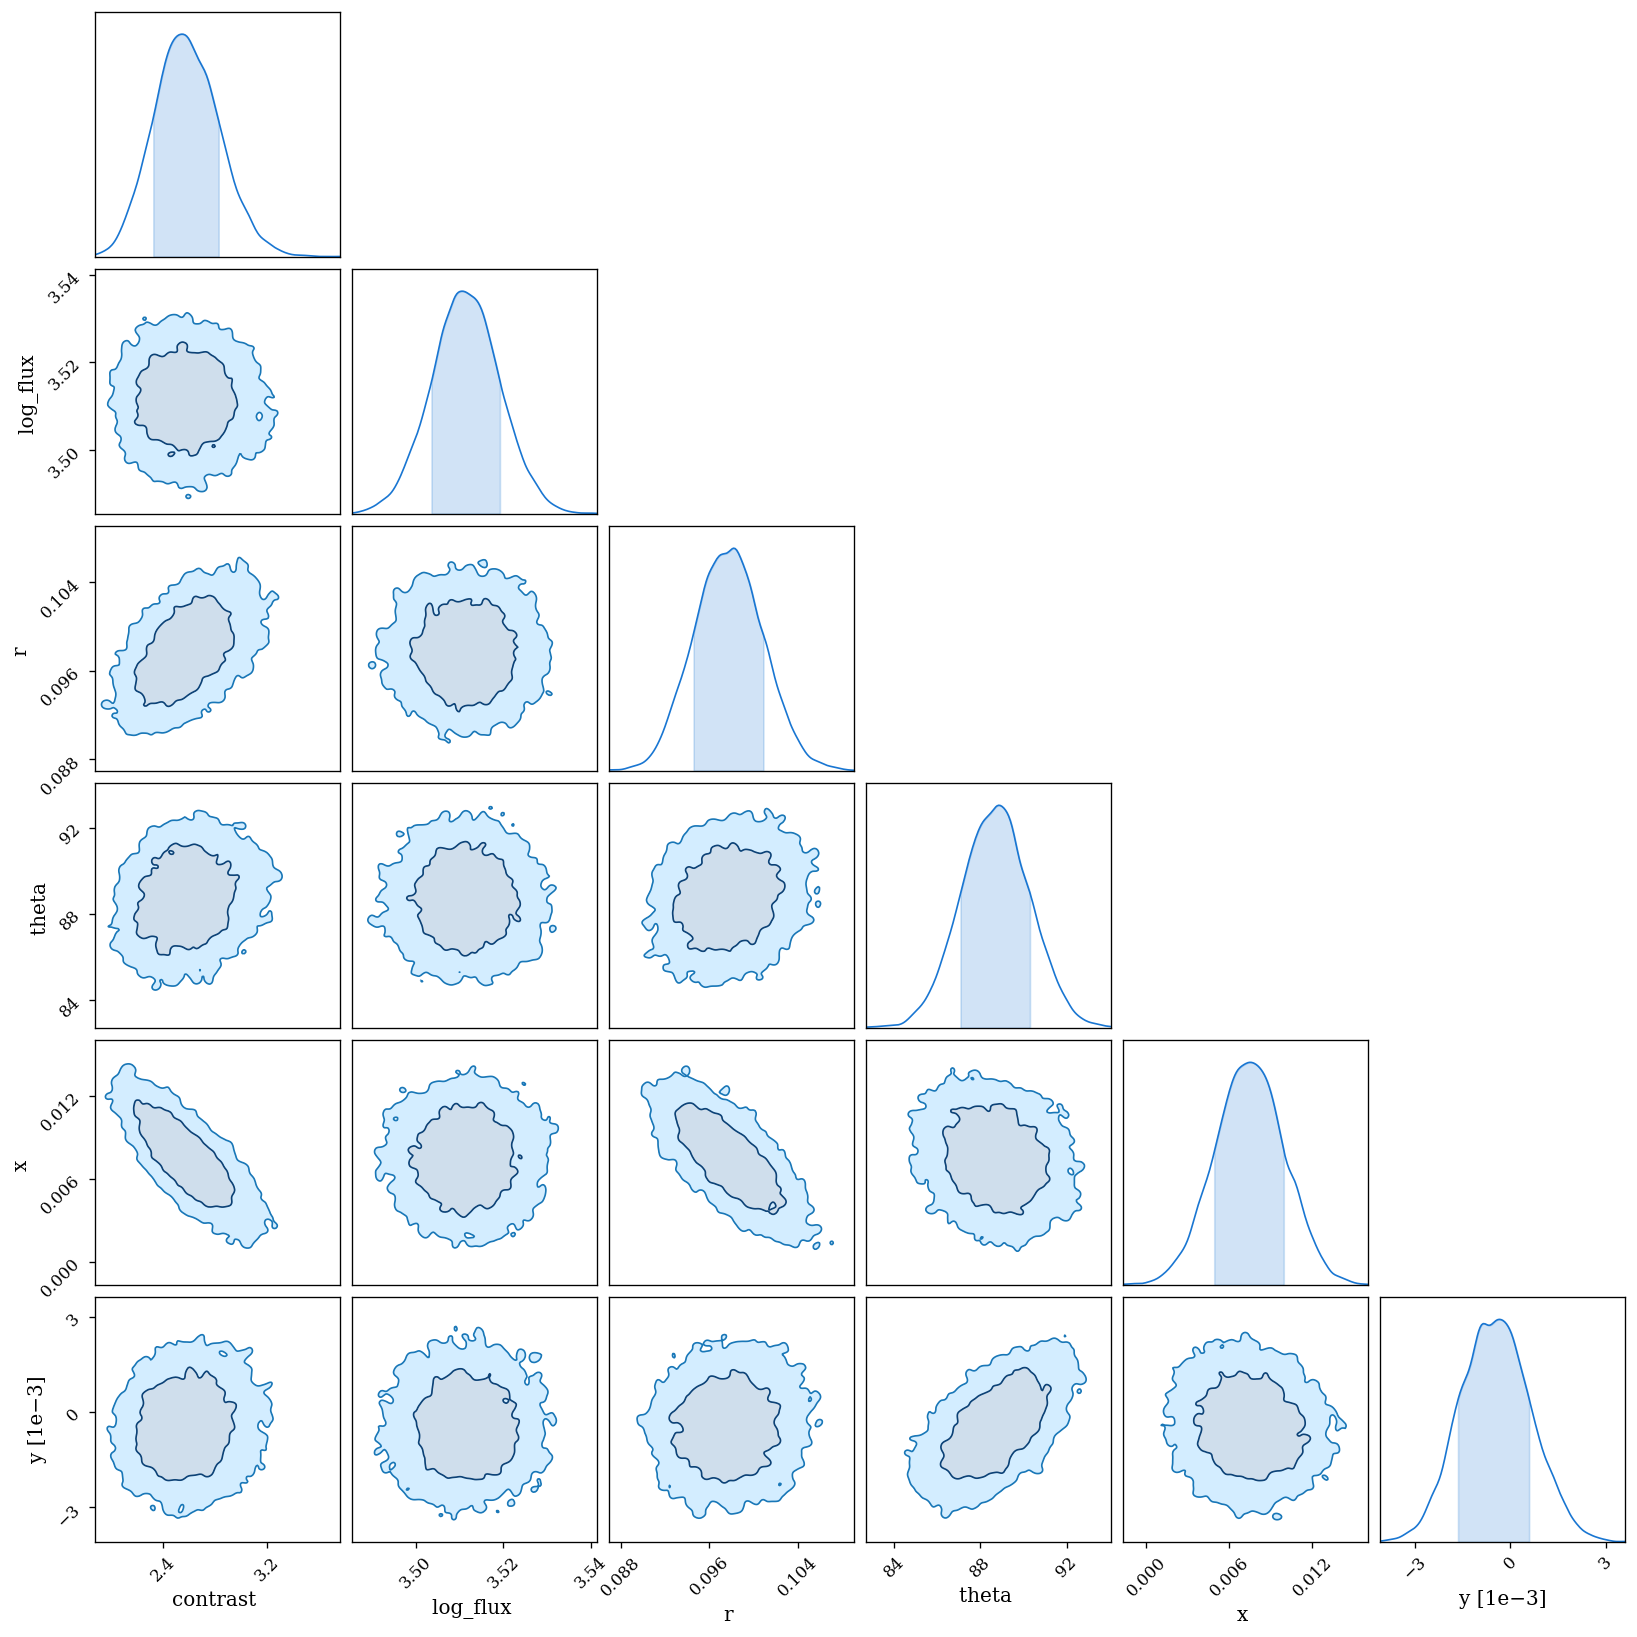

In [22]:
import chainconsumer as cc

chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot()
fig.set_size_inches((15,15));

Excellent! All the parameters are well constrained.